# <center> <font color = "green"> **Déploiement d'un modèle dans le cloud**

## <font color = "#5DoD6E"> **Description du projet :** <br>
<font color = "black"> La start-up de l'AgriTech, nommée "Fruits!", cherche à proposer des solutions innovantes pour la récolte des fruits. La volonté de l’entreprise est de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruits en développant des robots cueilleurs intelligents.

La start-up souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit. 

Cette application permettrait de sensibiliser le grand public à la biodiversité des fruits et de mettre en place une première version du moteur de classification des images de fruits. De plus, le développement de l’application mobile permettra de construire une première version de l'architecture Big Data nécessaire.

## <font color = "#5DoD6E"> **Objectifs de ce projet :** <br>
<font color = "black"> 

* Développer une première chaîne de traitement des données qui comprendra le preprocessing et une étape de réduction de dimension.
* Tenir compte du fait que le volume de données va augmentertrès rapidement après la livraison de ce projet, ce qui implique de:
     - Déployer le traitement des données dans un environnement Big Data.
     - Développer les scripts en pyspark pour effectuer du calcul distribué.

## <font color = "#5DoD6E"> **Méthodologie**

#### <font color = "ED4353"> **Mettre en place le calcul distribué :**
<font color = "black"> Développer des scripts en pyspark afin de prévenir l’augmentation très rapide du volume de donné après la livraison du projet.

#### <font color = "ED4353"> **Transfert learning :**
<font color = "black"> La statup ne souhaite pas, pour l'intstant, entraîner un modèle. Mais étant donné qu'il faille réaliser une première chaîne de traitement des données qui comprendra le preprocessing et une étape de réduction de dimension, je vais me servir du transfert learning afin d'utiliser la connaissance déjà acquise par un modèle entraîné (VGG16) pour l'adapter à cette problématique.

#### <font color = "ED4353"> **Déploiement de la solution sur le cloud :**
<font color = "black"> Le prestataire le plus connu et qui offre à ce jour l'offre la plus large dans le cloud computing est Amazon Web Services (AWS). Certaines de leurs offres sont parfaitement adaptées à cette problématique

## <font color = "#5DoD6E"> **1. Importation des librairies et définition des fonctions**

#### <font color = "#5DoD6E"> **1.1. Importation des librairies**

In [1]:
# Librairies pour la manipulation de données
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split, udf
from pyspark.sql.types import *

# Librairies pour le traitement d'images
from PIL import Image
import numpy as np
import io
import os
from keras.preprocessing.image import img_to_array
from pyspark.ml.image import ImageSchema

# Librairies pour la visualisation
import matplotlib.pyplot as plt

# Librairies pour l'apprentissage automatique (Deep Learning)
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# Librairies pour le traitement des données vectorielles
from pyspark.ml.feature import PCA  
from pyspark.ml.linalg import Vectors, VectorUDT

# Autre
import findspark

#### <font color = "#5DoD6E">  **1.2. Chargement et traitement des données**

**Définition des PATH pour le chargement et l'enregistrement des résultats.**

In [2]:
# Chemin vers le répertoire des données
PATH_Data = r"C:\Users\alain\OneDrive\Documents\Formation Data scientist\projet_8\data\data_test"

# Chemin vers le répertoire des résultats
PATH_Result = r"C:\Users\alain\OneDrive\Documents\Formation Data scientist\projet_8\data\data_results"

**Création de la SparkSession**

L’application Spark est contrôlée grâce à un processus de pilotage (driver process) appelé SparkSession. Une instance de **_SparkSession_** est la façon dont Spark exécute les fonctions définies par l’utilisateur
dans l’ensemble du cluster. Une SparkSession correspond toujours à une application Spark. <br> Pour fonctionner correctement, Spark doit être trouvé par Python lors de l'exécution de scripts. Cependant, il n'est pas toujours automatiquement accessible depuis Python.Pour résoudre ce problème, je vais définir la fonction **_findspark_** qui aura pour rôle principal de permettre à un script Python d'accéder à l'installation de Spark sur ce PC.

In [3]:
# Intégration de Spark dans l'environnement Python
findspark.init()

In [4]:
# Création d'une session Spark
spark = (
    SparkSession
    .builder
    .config("spark.driver.memory", "25g")
    .config("spark.executor.memory", "20g")
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.2.0')
    .config("spark.sql.parquet.writeLegacyFormat", 'true')
    .config('spark.driver.maxResultSize', '20G')
    .config('spark.driver.host', 'localhost')
    .master('local')
    .appName('projet_8')
    .getOrCreate()
)

In [5]:
# Récupération du SparkContext à partir de la session Spark
sc = spark.sparkContext

In [6]:
# Affichage des informations de Spark en cours d'execution
spark

**Chargement des données**

Les images sont chargées au format binaire, ce qui offre, plus de souplesse dans la façon de prétraiter les images.<br>
Je ne vais charger que les fichiers dont l'extension est jpg. J'ai utilisé 5 friuts pour réaliser ce projet en local : Apple_Golden_1, Apple_Red_delicios_1, apple_6, pear_3 et apple_pink_lady_1

In [7]:
# Lecture des fichiers binaires (images) à partir d'un répertoire avec Spark
images = (
    spark  # Utilisation de la session Spark précédemment créée
    .read  # Méthode pour lire des données dans Spark
    .format("binaryFile")  # Spécification du format des fichiers (ici, fichiers binaires)
    .option("pathGlobFilter", "*.jpg")  # Filtrage des fichiers pour inclure uniquement ceux avec l'extension .jpg
    .option("recursiveFileLookup", "true")  # Activation de la recherche récursive des fichiers dans les sous-répertoires
    .load(PATH_Data)  # Chargement des fichiers binaires à partir du chemin spécifié (PATH_Data)
)

In [8]:
# Visualisation
images.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/C:/Users/al...|2023-11-28 03:38:...| 78796|[FF D8 FF E0 00 1...|
|file:/C:/Users/al...|2023-11-28 03:38:...| 78179|[FF D8 FF E0 00 1...|
|file:/C:/Users/al...|2023-11-28 03:38:...| 78142|[FF D8 FF E0 00 1...|
|file:/C:/Users/al...|2023-11-28 03:38:...| 78115|[FF D8 FF E0 00 1...|
|file:/C:/Users/al...|2023-11-28 03:38:...| 77820|[FF D8 FF E0 00 1...|
|file:/C:/Users/al...|2023-11-28 03:38:...| 77580|[FF D8 FF E0 00 1...|
|file:/C:/Users/al...|2023-11-28 03:38:...| 77527|[FF D8 FF E0 00 1...|
|file:/C:/Users/al...|2023-11-28 03:38:...| 77515|[FF D8 FF E0 00 1...|
|file:/C:/Users/al...|2023-11-28 03:38:...| 77506|[FF D8 FF E0 00 1...|
|file:/C:/Users/al...|2023-11-28 03:38:...| 77421|[FF D8 FF E0 00 1...|
|file:/C:/Users/al...|2023-11-28 03:38:...| 77205|[FF D8 FF E0 0

In [9]:
# Nombre d'image
images.count()

1380

Ajout d'une colonne **_"label_"** au DataFrame **_"images_"**, dérivée de la dernière partie du chemin des fichiers dans la colonne **_"path"_**.

In [10]:
# Ajout d'une colonne 'label' au DataFrame 'images'
images = images.withColumn('label', element_at(split(images['path'], '/'), -2))

# Impression du schéma du DataFrame 'images'
print(images.printSchema())

# Sélection des colonnes 'path' et 'label' et affichage des six premières lignes
print(images.select('path', 'label').show(6, False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+----------------------------------------------------------------------------------------------------------+------+
|path                                                                                                      |label |
+----------------------------------------------------------------------------------------------------------+------+
|file:/C:/Users/alain/OneDrive/Documents/Formation Data scientist/projet_8/data/data_test/pear_3/r0_148.jpg|pear_3|
|file:/C:/Users/alain/OneDrive/Documents/Formation Data scientist/projet_8/data/data_test/pear_3/r0_146.jpg|pear_3|
|file:/C:/Users/alain/OneDrive/Documents/Formation Data scientist/projet_8/data/data_test/pear_3/r0_142.jpg|pear_3|
|file:/C:/Users/alain/OneDrive/Documents/Formation Data scientist/projet_8/data/data_test/pear

#### <font color = "#5DoD6E">  **2.EXTRACTION DES FEATURES**
<font color = "black"> 

Utilisation d'une approche de featurization de des images par transfer learning.

Cela consiste à extraire les features les plus pertinentes pour la classification de nos iamges en utilisant un modèle de deep learning pré-entraîné sur de la classification d'image, auquel on enlève la dernière couche - celle qui classifie - afin d'obtenir en sortie un tenseur des features les plus significatives de nos images.

Ce tenseur pourra ensuite être fourni à un autre modèle de classification, qui sera ainsi adapté à nos classes.

Nous utilisons la technique du **transfert learning** pour extraire les features des images.
J'ai choisi d'utiliser le modèle **MobileNetV2** pour sa rapidité d'exécution comparée à d'autres modèles comme VGG16 par exemple.

L'idée dans ce projet est de récupérer le vecteur de caractéristiques de dimensions (1,1,1280) qui servira, plus tard, au travers d'un moteur de classification à reconnaitre les différents fruits du jeu de données.

In [11]:
# Chargement du modèle MobileNetV2 pré-entraîné sur ImageNet
# Le paramètre 'weights' spécifie que les poids pré-entraînés sur le jeu de données ImageNet doivent être utilisés.
# Le paramètre 'include_top' indique si les couches fully connected (FC) situées au sommet du réseau doivent être incluses.
# Le paramètre 'input_shape' définit la forme attendue de l'entrée du modèle.
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

# Création d'un nouveau modèle en excluant la dernière couche fully connected (FC)
# Cela permet d'obtenir un modèle sans la couche de prédiction d'ImageNet.
new_model = Model(inputs=model.input,           
                  outputs=model.layers[-2].output)

In [12]:
# Affichage du résumé du nouveau modèle 
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

**Tous les workeurs doivent pouvoir accéder au modèle ainsi qu'à ses poids. Une bonne pratique consiste à charger le modèle sur le driver puis à diffuser ensuite les poids aux différents workeurs.**

In [13]:
# Diffusion des poids du modèle aux nœuds du cluster Spark
# La fonction broadcast permet de distribuer efficacement des variables aux travailleurs du cluster Spark.
broadcast_weights = sc.broadcast(new_model.get_weights())


#### <font color = "#5DoD6E">  **3. Processus de chargement des images et application de leur featurisation à travers l'utilisation de pandas UDF**

**Création d'un nouveau modèle basé sur MobileNetV2 avec des poids pré-entraînés.**

In [14]:
def model_fn():
    """
    Fonction pour créer un nouveau modèle basé sur MobileNetV2 avec des poids pré-entrainés.

    Returns:
    - new_model (keras.Model): Un modèle basé sur MobileNetV2 avec les poids pré-entrainés.
    """

    # Chargement du modèle MobileNetV2 pré-entrainé sur ImageNet. Le modèle complet est chargé avec toutes ses couches.
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))

    # Désactivation de l'entraînement pour toutes les couches du modèle. Ceci est fait pour geler les poids du modèle pré-entrainé afin de les conserver.
    for layer in model.layers:
        layer.trainable = False

    # Création d'un nouveau modèle en excluant la dernière couche fully connected (FC). Cela permet d'obtenir un modèle sans la couche de prédiction d'ImageNet.
    new_model = Model(inputs=model.input,
                      outputs=model.layers[-2].output)

    # Initialisation des poids du nouveau modèle avec les poids diffusés
    new_model.set_weights(broadcast_weights.value)

    return new_model

In [15]:
def preprocess(content):
    """
    Fonction de prétraitement pour convertir le contenu d'une image en tableau d'entrée pour le modèle.

    Args:
    - content (bytes): Contenu de l'image en format binaire.

    Returns:
    - arr (numpy.ndarray): Tableau d'entrée prétraité pour le modèle.
    """
    # Ouverture de l'image, redimensionnement et conversion en tableau
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    # Prétraitement spécifique à MobileNetV2
    return preprocess_input(arr)

In [16]:
def featurize_series(model, content_series):
    """
    Fonction pour extraire les caractéristiques (features) à partir d'une série de contenus d'images.

    Args:
    - model (keras.Model): Modèle utilisé pour l'extraction des caractéristiques.
    - content_series (pandas.Series): Série de contenus d'images.

    Returns:
    - pd.Series: Série de caractéristiques extraites.
    """
    # Prétraitement des images dans la série
    input = np.stack(content_series.map(preprocess))
    # Prédiction des caractéristiques à l'aide du modèle
    preds = model.predict(input)
    # Aplatir les caractéristiques pour un stockage plus facile dans les DataFrames Spark
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [17]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    """
    Fonction UDF Pandas pour extraire les caractéristiques d'un lot de contenus d'images.

    Args:
    - content_series_iter: Itérateur de séries de contenus d'images.

    Yields:
    - pd.Series: Série de caractéristiques extraites.
    """
    # Chargement du modèle une seule fois pour amortir les frais généraux
    model = model_fn()
    for content_series in content_series_iter:
        # Rendement des caractéristiques extraites pour chaque série de contenus
        yield featurize_series(model, content_series)

c:\Users\alain\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\pandas\functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


**Exécution des actions d'extraction de features**

_**Remarque** : Les Pandas UDF, sur de grands enregistrements (par exemple, de très grandes images), peuvent rencontrer des erreurs de type Out Of Memory (OOM), pour eviter ce probléme on réduit la taille du lot Arrow via 'maxRecordsPerBatch'_

In [18]:
# Limitation du nombre de lignes par lot lors de l'utilisation d'Arrow
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [19]:
# Création d'un DataFrame de caractéristiques à partir des images
features_df = (
    images  # DataFrame contenant les informations sur les images
    .repartition(20)  # Répartition des données en 20 partitions pour le traitement parallèle
    .select(
        col("path"),  # Sélection de la colonne 'path' contenant les chemins des images
        col("label"),  # Sélection de la colonne 'label' contenant les libellés des images
        featurize_udf("content").alias("features")  # Application de la fonction UDF pour extraire les caractéristiques
    )
)

In [20]:
features_df.show(10)

+--------------------+--------------------+--------------------+
|                path|               label|            features|
+--------------------+--------------------+--------------------+
|file:/C:/Users/al...|              pear_3|[1.0428792, 0.310...|
|file:/C:/Users/al...|              pear_3|[1.0726149, 0.240...|
|file:/C:/Users/al...|              pear_3|[0.68280464, 0.14...|
|file:/C:/Users/al...|              pear_3|[0.5757859, 0.065...|
|file:/C:/Users/al...|              pear_3|[0.1952559, 0.152...|
|file:/C:/Users/al...|              pear_3|[0.14478278, 0.02...|
|file:/C:/Users/al...|apple_red_delicios_1|[0.09588556, 0.0,...|
|file:/C:/Users/al...|              pear_3|[0.26750854, 0.18...|
|file:/C:/Users/al...|apple_red_delicios_1|[0.24852274, 0.12...|
|file:/C:/Users/al...|apple_red_delicios_1|[0.36039332, 0.08...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



#### <font color = "#5DoD6E">  **4. REDUCTION DE DIMENION (PCA)**

Les features sont de type array, je les convertir en Type Vector.

In [21]:
#Construction d'une User defined Fonction qui transforme les listes de features en vecteurs denses.
array_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

In [22]:
# Création d'un DataFrame vectorisé à partir des caractéristiques extraites
vectorized_df = features_df.withColumn('cnn_vectors', array_to_vector_udf('features'))

In [23]:
vectorized_df.limit(6).show()

+--------------------+------+--------------------+--------------------+
|                path| label|            features|         cnn_vectors|
+--------------------+------+--------------------+--------------------+
|file:/C:/Users/al...|pear_3|[1.0428792, 0.310...|[1.04287922382354...|
|file:/C:/Users/al...|pear_3|[1.0726149, 0.240...|[1.07261490821838...|
|file:/C:/Users/al...|pear_3|[0.68280464, 0.14...|[0.68280464410781...|
|file:/C:/Users/al...|pear_3|[0.5757859, 0.065...|[0.57578587532043...|
|file:/C:/Users/al...|pear_3|[0.1952559, 0.152...|[0.19525590538978...|
|file:/C:/Users/al...|pear_3|[0.14478278, 0.02...|[0.14478278160095...|
+--------------------+------+--------------------+--------------------+



**Recherche du nombre de composantes optimales via l'ACP**

In [24]:
# Fonction pour réduction de dimensions PCA
def reduc_dim_pca(features):
    '''Réduction des dimensions PCA sur les feature
    Entrée:
    - features de l\'image
    
    Retour:
    - pca
    - pca_matrix: résultat de la réduction de dimensions
    '''
    # Conversion d'un tableau (array) en vecteur dense
    # Création d'un fonction utilisateur avec udf
    #vector_dense = udf(lambda x: Vectors.dense(x), VectorUDT())
    img_vd_df = features.select("path","label","cnn_vectors")
    
    # PCA
    pca_spark = PCA(inputCol="cnn_vectors", outputCol="features_pca", k=100)
    pca = pca_spark.fit(img_vd_df)
    pca_matrix = pca.transform(img_vd_df)
    
    return pca, pca_matrix

In [27]:
# Appelle de la fonction pour la réduction de dimension PCA
pca, pca_matrix = reduc_dim_pca(vectorized_df)


In [28]:
pca_matrix.show(20)

+--------------------+--------------------+--------------------+--------------------+
|                path|               label|         cnn_vectors|        features_pca|
+--------------------+--------------------+--------------------+--------------------+
|file:/C:/Users/al...|              pear_3|[1.04287922382354...|[5.40511583360912...|
|file:/C:/Users/al...|              pear_3|[1.07261490821838...|[6.05396928874009...|
|file:/C:/Users/al...|              pear_3|[0.68280464410781...|[5.02777186981379...|
|file:/C:/Users/al...|              pear_3|[0.57578587532043...|[1.07586124453899...|
|file:/C:/Users/al...|              pear_3|[0.19525590538978...|[-0.1880234431689...|
|file:/C:/Users/al...|              pear_3|[0.14478278160095...|[4.15989260392300...|
|file:/C:/Users/al...|apple_red_delicios_1|[0.09588555991649...|[-6.1089727721663...|
|file:/C:/Users/al...|              pear_3|[0.26750853657722...|[-0.3534779778654...|
|file:/C:/Users/al...|apple_red_delicios_1|[0.24852274

In [29]:
# Fonction pour l'affichage du diagramme des éboulis PCA
def display_pca_eboulis(pca):
    '''Affichage du diagramme des éboulis sur PCA
    Entrée:
    - pca
    
    Retour:
    - N/A
    '''
    # Variance expliquée
    varexpl = pca.explainedVariance*100
        
    # Affichage de la variance cumulée
    plt.figure(figsize=(11,7))
    plt.bar(np.arange(len(varexpl))+1, varexpl)

    cumSumVar = varexpl.cumsum()
    plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
    plt.axhline(y=90, linestyle="--", 
                color="green",
                linewidth=1)

    limit = 90
    valid_idx = np.where(cumSumVar >= limit)[0]
    min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
    plt.axvline(x=min_plans, linestyle="--", 
                color="green",
                linewidth=1)

    plt.xlabel("Rang de l'axe d'inertie pour les composantes K")
    plt.xticks(np.arange(0,105,5))
    plt.xlim(left=0)
    plt.ylabel("Pourcentage d'inertie")
    plt.title("{}% de la variance totale est expliquée"\
                " par les {} premiers axes".format(limit,
                                            min_plans))
    plt.show(block=False)
        
    return None

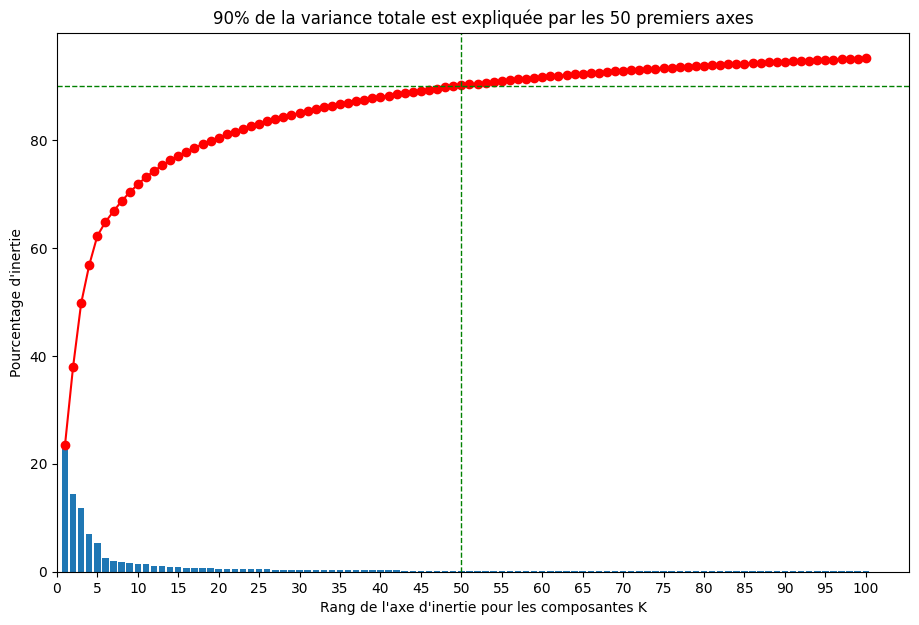

In [30]:
# Affichage du diagramme des éboulis
display_pca_eboulis(pca)

In [31]:
# Transformation inverse (de Vectors à Arrays)
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

In [32]:
final_df = pca_matrix.withColumn('features', vector_to_array_udf('features_pca'))

In [33]:
final_df.show(6, True)

+--------------------+------+--------------------+--------------------+--------------------+
|                path| label|         cnn_vectors|        features_pca|            features|
+--------------------+------+--------------------+--------------------+--------------------+
|file:/C:/Users/al...|pear_3|[1.04287922382354...|[5.40511583360912...|[5.4051156, 7.183...|
|file:/C:/Users/al...|pear_3|[1.07261490821838...|[6.05396928874009...|[6.0539694, 6.859...|
|file:/C:/Users/al...|pear_3|[0.68280464410781...|[5.02777186981379...|[5.027772, 6.9215...|
|file:/C:/Users/al...|pear_3|[0.57578587532043...|[1.07586124453899...|[1.0758612, 8.035...|
|file:/C:/Users/al...|pear_3|[0.19525590538978...|[-0.1880234431689...|[-0.18802345, 8.6...|
|file:/C:/Users/al...|pear_3|[0.14478278160095...|[4.15989260392300...|[4.1598926, 6.956...|
+--------------------+------+--------------------+--------------------+--------------------+
only showing top 6 rows



**Enregistrement des données traitées au format "parquet"**

In [34]:
# Enregistrement des données (format parquet)
final_df.write.mode('overwrite').parquet(PATH_Result)

**Chargement des données enregistrées et validation du résultat**

In [35]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

In [36]:
df

,path,label,cnn_vectors,features_pca,features
0,file:/C:/Users/alain/OneDrive/Documents/Format...,pear_3,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[5.4051156, 7.1830473, 0.44904786, 19.976051, ..."
1,file:/C:/Users/alain/OneDrive/Documents/Format...,pear_3,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[6.0539694, 6.8592887, 1.4605814, 18.879694, -..."
2,file:/C:/Users/alain/OneDrive/Documents/Format...,pear_3,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[5.027772, 6.9215565, 1.6539627, 18.330875, -0..."
3,file:/C:/Users/alain/OneDrive/Documents/Format...,pear_3,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[1.0758612, 8.035203, 3.1161194, 15.167354, -4..."
4,file:/C:/Users/alain/OneDrive/Documents/Format...,pear_3,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-0.18802345, 8.618432, 2.631305, 12.940316, -..."
...,...,...,...,...,...
1375,file:/C:/Users/alain/OneDrive/Documents/Format...,apple_6,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-0.36410218, 15.81337, -5.6720376, 4.299677, ..."
1376,file:/C:/Users/alain/OneDrive/Documents/Format...,apple_6,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-1.9880258, 16.53656, -5.3062186, 3.434158, -..."
1377,file:/C:/Users/alain/OneDrive/Documents/Format...,apple_6,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-1.4048449, 15.619354, -4.4052153, 3.997469, ..."
1378,file:/C:/Users/alain/OneDrive/Documents/Format...,apple_6,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-0.033618003, 14.356378, -4.9591737, 2.346966..."


In [39]:
# Enregistrement du dataframe df au format csv
df.to_csv('data_pca.csv', index=False)

### Arrêt de la session Spark
Arrêt de la session Spark pour permettre la libération des ressources (mémoire Java, processeur,...).

In [37]:
# Arrêt de la session Spark
spark.stop()